In [2]:
import glob
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
from sklearn.metrics import log_loss

In [5]:
sys.path.append('..')
from metrics import brier_multi, CalibrationErrors, classification_error
from settings import project_root

Using TensorFlow backend.


## Load Data

In [6]:
from keras.datasets import mnist
from keras.utils import to_categorical

def load_mnist():
    num_classes = 10
    (x_train_val, y_train_val), (x_test, y_test) = mnist.load_data()
    x_train_val = x_train_val.reshape(x_train_val.shape[0], 784)
    x_test = x_test.reshape(x_test.shape[0], 784)

    x_train_val = x_train_val.astype('float32')
    x_test = x_test.astype('float32')

    x_train_val /= 255
    x_test /= 255

    y_train_val = to_categorical(y_train_val, num_classes)
    y_test = to_categorical(y_test, num_classes)

    x_train = x_train_val[:50000]
    y_train = y_train_val[:50000]
    x_val = x_train_val[50000:]
    y_val = y_train_val[50000:]
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist()

## Model
* The model is similar to the one that was used in Deep Ensembles and XXX paper
* TODO: try a version of the model without batch normalization and study the effect

In [8]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.layers.core import Lambda

from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.optimizers import Adam
from keras import backend as K

In [9]:
def mlp(num_classes=10):
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape=(784,)))
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    return model

## Todo

In [10]:
n_models = 25
learning_rate = 2.5e-3
epochs = 15
output_folder = os.path.join(project_root, 'mnist_mlp')
if not os.path.isdir(output_folder):
    os.makedirs(output_folder)
#
output_baseline_folder = os.path.join(output_folder, 'baselines')
if not os.path.isdir(output_baseline_folder):
    os.makedirs(output_baseline_folder)

In [11]:
for i in range(n_models):
    seed = i+17
    # change the random state
    np.random.seed(seed)
    # creating output folder for each of the baseline models
    output_model_folder = os.path.join(output_baseline_folder, str(seed))
    if not os.path.isdir(output_model_folder):
        os.mkdir(output_model_folder)
    else:
        print('skipped training...')
        continue
    # callbacks for training
    callbacks = list()
    log = CSVLogger(os.path.join(output_model_folder, 'log.csv'))
    callbacks.append(log)
    checkpoint_path = os.path.join(output_model_folder, 'weights.{epoch:02d}.hdf5')
    checkpoint = ModelCheckpoint(checkpoint_path, period=1, save_best_only=False, verbose=True)
    callbacks.append(checkpoint)
    # initialize and compile the model
    model = mlp()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    # train
    model.fit(x_train, y_train, batch_size=128, epochs=epochs, verbose=1, callbacks=callbacks, validation_data=(x_val, y_val), shuffle=True)

skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...
skipped training...


/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)
/home/mehrtash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplo

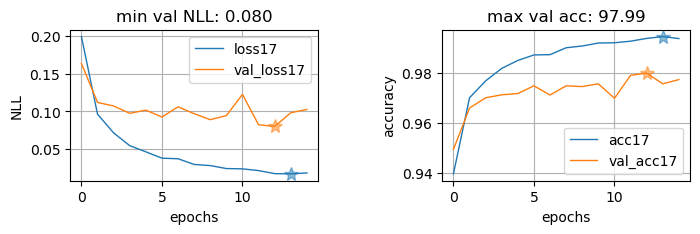

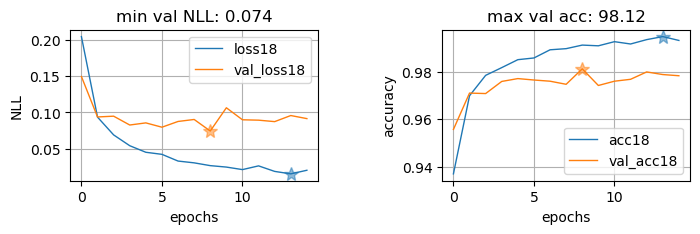

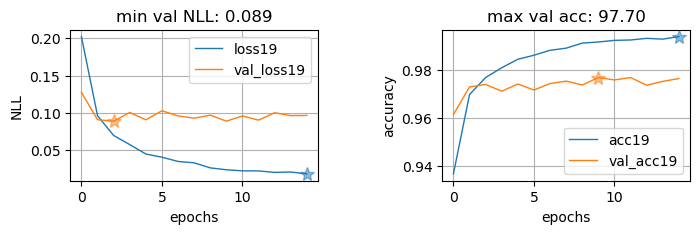

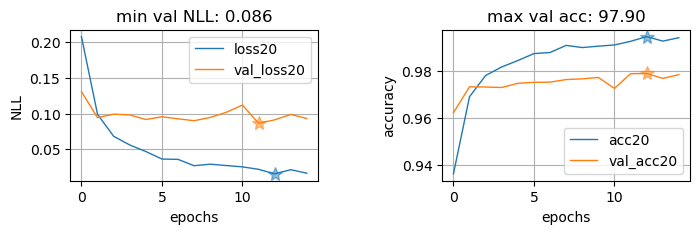

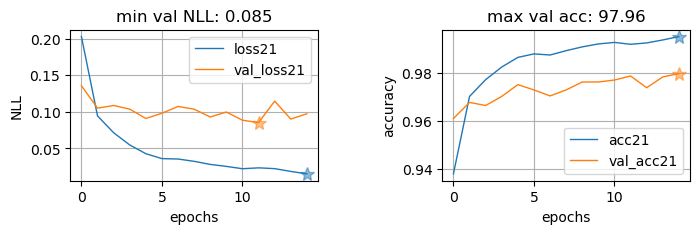

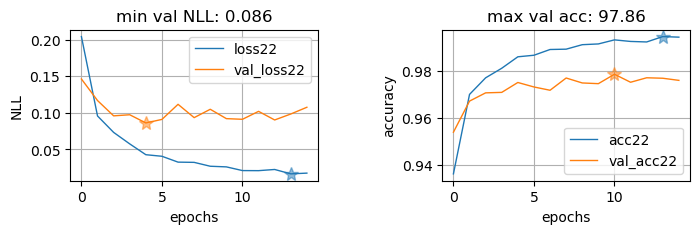

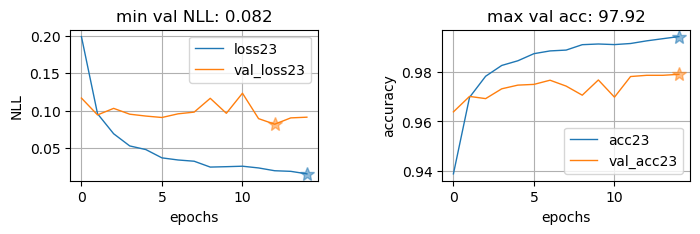

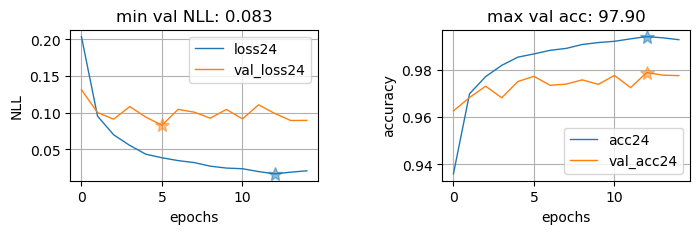

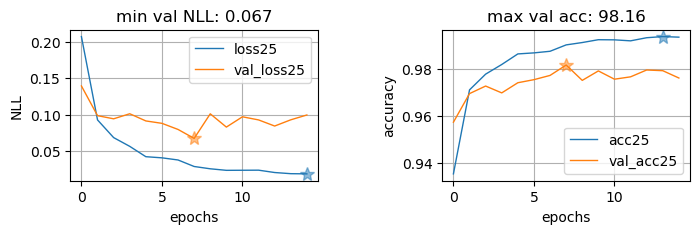

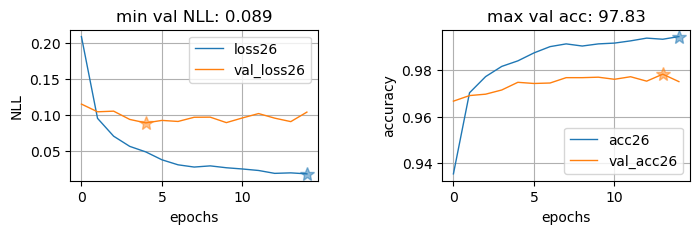

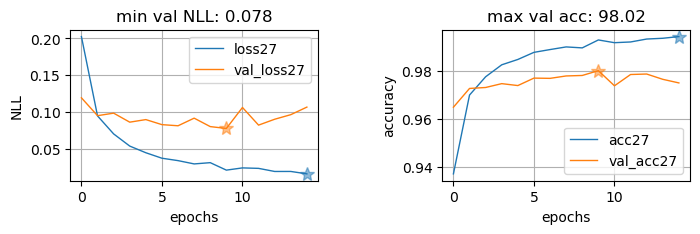

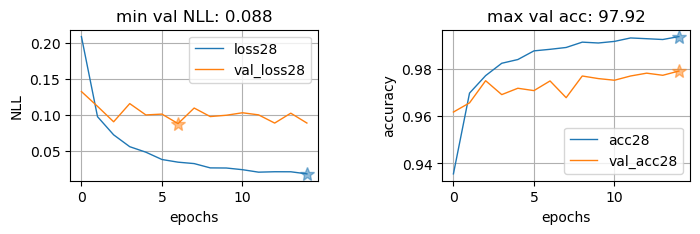

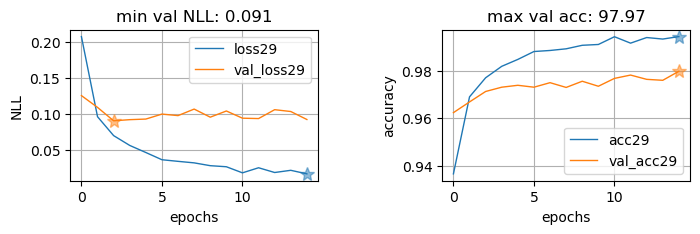

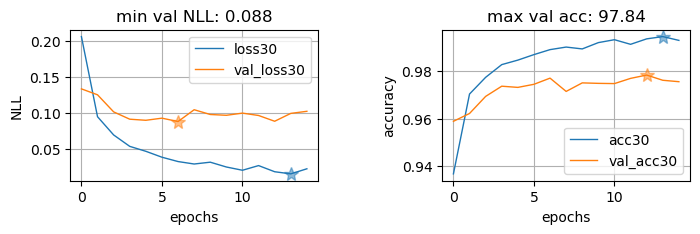

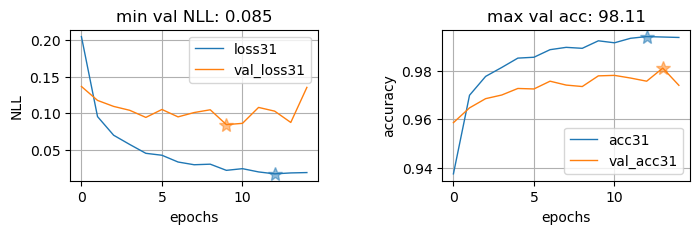

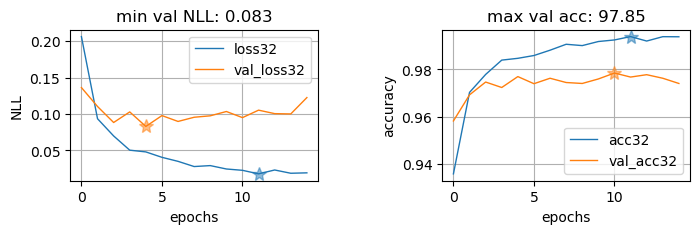

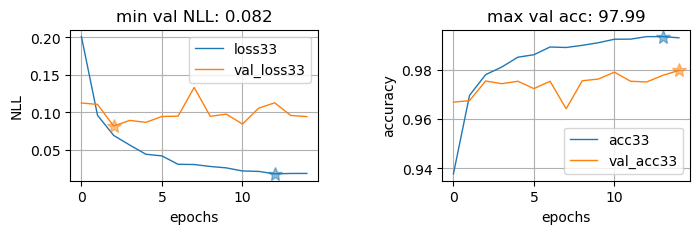

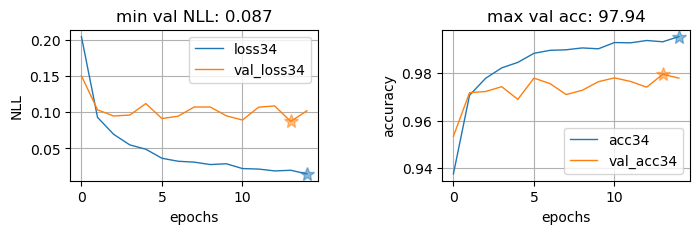

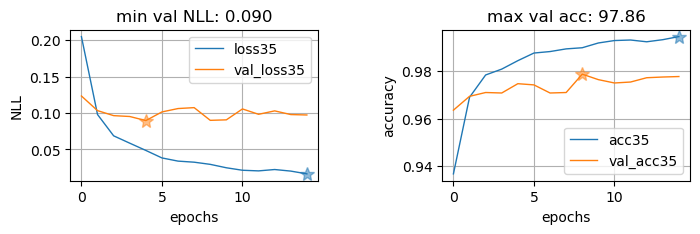

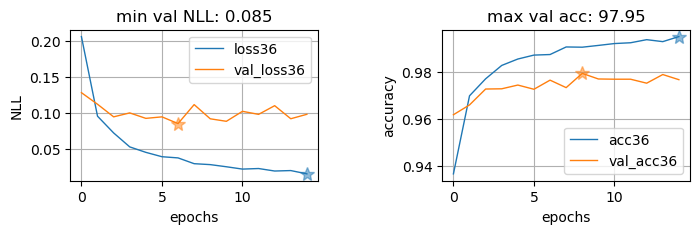

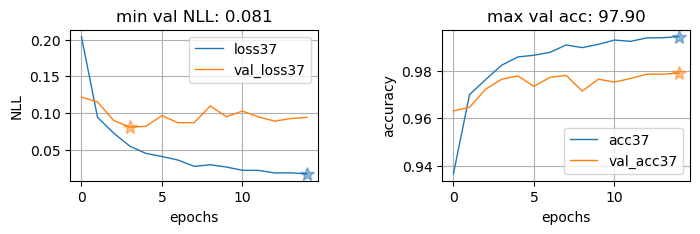

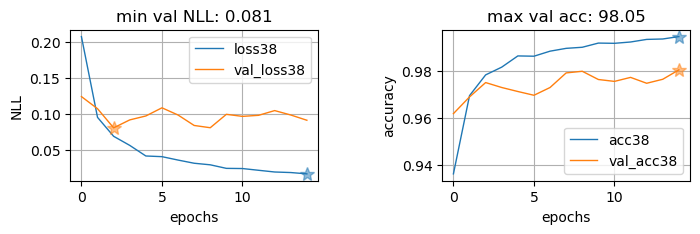

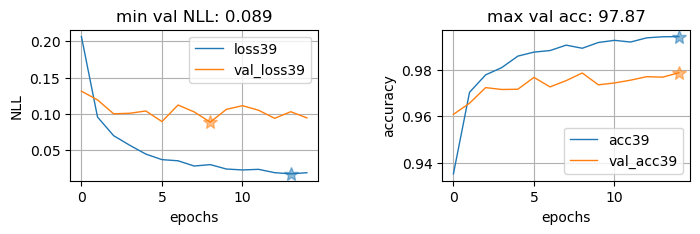

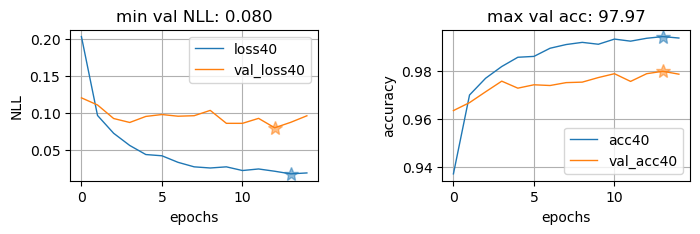

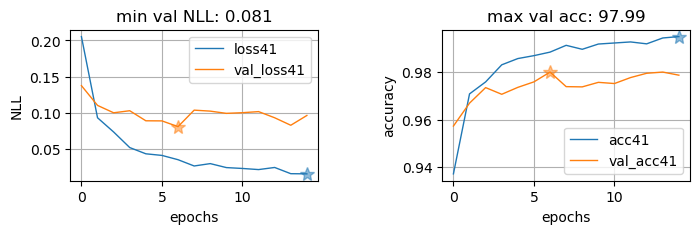

In [12]:
for i in range(17, 17+n_models):
    log = pd.read_csv(os.path.join(output_baseline_folder, str(i), 'log.csv'))
    plt.figure(figsize=(8,2),dpi=100)
    plt.subplots_adjust(wspace=0.5)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    for metric_type in ['', 'val_']:
        for key in log.keys():
            if 'loss' in key and 'val' not in key:
                p = ax1.plot(log[metric_type+ key], label=metric_type + key+str(i), linewidth=1)
                c = p[-1].get_color()
                ax1.plot(np.argmin(log[metric_type+key]), np.amin(log[metric_type+key]), 
                         '*', markersize=10, alpha=0.5, color = c)
                ax1.set_title('min val NLL: {0:.3f}'.format(np.amin(log['val_' + key])))
                ax1.set_ylabel('NLL')
                ax1.set_xlabel('epochs')
            if 'acc' in key and 'val' not in key:
                p = ax2.plot(log[metric_type + key], label=metric_type + key+str(i), linewidth=1)
                c = p[-1].get_color()
                ax2.plot(np.argmax(log[metric_type + key]), np.amax(log[metric_type + key]), 
                         '*', markersize=10, alpha=0.5, color=c)
                ax2.set_title('max val acc: {0:.2f}'.format(np.amax(log['val_' + key]*100)))
                ax2.set_ylabel('accuracy')
                ax2.set_xlabel('epochs')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()

In [13]:
for index, model_id in enumerate(range(17, 17+n_models)):
    model_folder = os.path.join(output_baseline_folder, str(model_id))
    test_pred_path = os.path.join(model_folder, 'test_pred.npy')
    # if True:
    if not os.path.isfile(test_pred_path):
        checkpoint_path = glob.glob( model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp()
        print('loading weights for model {}...'.format(model_id))
        model.load_weights(checkpoint_path)
        print('running inference...')
        test_pred = model.predict(x_test)
        np.save(test_pred_path, test_pred)

In [14]:
sample_model_id = 17
y_pred_sample = np.load(os.path.join(output_baseline_folder, str(sample_model_id), 'test_pred.npy'))
shape = np.shape(y_pred_sample)
all_test_preds = np.zeros((n_models, *shape))

In [15]:
d = []
for index, model_id in enumerate(range(17, 17+n_models)):
    y_pred = np.load(os.path.join(output_baseline_folder, str(model_id), 'test_pred.npy'))
    all_test_preds[index] = y_pred
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_baselines = pd.DataFrame(d)

In [16]:
print(df_baselines)

    model       nll     brier       ece        mce  classification error
0      17  0.085811  0.036027  1.212307  66.113958                  2.29
1      18  0.088970  0.035416  1.293205  30.072403                  2.19
2      19  0.083936  0.035472  1.317934  26.070374                  2.23
3      20  0.090023  0.035112  1.139185  37.549862                  2.10
4      21  0.092218  0.035476  1.343740  29.371622                  2.26
5      22  0.118141  0.042232  1.489946  20.196827                  2.49
6      23  0.097130  0.037205  1.411669  39.474791                  2.29
7      24  0.085837  0.035658  1.225365  37.476841                  2.20
8      25  0.101171  0.038938  1.412432  38.668972                  2.40
9      26  0.105199  0.041657  1.461620  19.777432                  2.57
10     27  0.103741  0.040022  1.449721  29.872349                  2.42
11     28  0.075225  0.030420  1.017944  62.407127                  1.92
12     29  0.078692  0.029996  1.035537  32.658288 

In [17]:
print('Baseline Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.2f}'.format(np.mean(df_baselines[metric]), np.std(df_baselines[metric])))
    print('-'*20)

BASELINE RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.095 ± 0.01
--------------------
BRIER
0.037 ± 0.00
--------------------
ECE
1.302 ± 0.19
--------------------
MCE
40.379 ± 14.80
--------------------
CLASSIFICATION ERROR
2.255 ± 0.22
--------------------


# Deep Ensembles

## TODO: Increase number of models and do bootstrapping for DE to provide std...

In [18]:
n_bootstrap = 100
m_deep_ensemble = 10

In [19]:
d = []
for i in range(n_bootstrap):
    model_indices = np.random.choice(np.shape(all_test_preds)[0], size=m_deep_ensemble, replace=False)
    y_pred = np.mean(np.stack(all_test_preds[model_indices], axis=0), axis=0)
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_deep_ensembles = pd.DataFrame(d)

In [20]:
df_deep_ensembles

,model,nll,brier,ece,mce,classification error
0,41,0.045298,0.020605,0.994108,17.561141,1.27
1,41,0.043021,0.019940,0.910200,46.833028,1.23
2,41,0.041633,0.019777,0.737164,73.195208,1.24
3,41,0.043183,0.020233,0.772780,27.802001,1.33
4,41,0.043473,0.020234,0.896324,46.618672,1.35
...,...,...,...,...,...,...
95,41,0.043710,0.020170,0.873415,18.763776,1.23
96,41,0.043257,0.019850,0.845719,71.404660,1.26
97,41,0.042759,0.020121,0.783511,72.969473,1.33
98,41,0.042617,0.019757,0.714397,27.754570,1.26


In [21]:
print('Deep Ensemble Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.2f}'.format(np.mean(df_deep_ensembles[metric]), np.std(df_deep_ensembles[metric])))
    print('-'*20)

DEEP ENSEMBLE RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.044 ± 0.00
--------------------
BRIER
0.020 ± 0.00
--------------------
ECE
0.848 ± 0.08
--------------------
MCE
35.646 ± 17.16
--------------------
CLASSIFICATION ERROR
1.294 ± 0.05
--------------------


# Temperature Scaling

In [22]:
from scipy.optimize import minimize
def softmax_t(y_logit, t):
    return np.exp(y_logit/t)/np.sum(np.exp(y_logit/t), axis=-1)[:, np.newaxis]


def ll_t(t):
    y_val_pred = model.predict(x_val)
    y_pred_base_logit = np.log(y_val_pred)
    y_pred_temp = softmax_t(y_pred_base_logit, t)
    ll = log_loss(y_val, y_pred_temp)
    return ll

In [23]:
optimal_temps = []
optimal_temps_path = os.path.join(output_baseline_folder, 'optimal_temps.csv')
# if True:
if not os.path.isfile(optimal_temps_path):
    for index, model_id in enumerate(range(17, 17+ n_models)):
        print('finding optimal sigma for model {}...'.format(model_id))
        model_folder = os.path.join(output_baseline_folder, str(model_id))
        checkpoint_path = glob.glob( model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp()
        print('loading weights...')
        model.load_weights(checkpoint_path)
        print('running optimization...')
        xopt = minimize(ll_t, 1, method='bfgs', options={'disp': 1})
        optimal_temp = xopt['x'][0]
        print('-'*100)
        print(model_id, optimal_temp)
        optimal_temps.append(optimal_temp)
    pd.DataFrame(optimal_temps, columns=['optimal temp']).to_csv(optimal_temps_path, index=False)
else:
    optimal_temps = pd.read_csv(optimal_temps_path).values
print(optimal_temps)

[[1.83782233]
 [1.80262627]
 [1.83544376]
 [1.74132693]
 [1.84628994]
 [1.88229666]
 [1.8191161 ]
 [1.77397803]
 [1.78677419]
 [1.79504745]
 [1.85553103]
 [1.76736516]
 [1.861452  ]
 [1.7241243 ]
 [1.98756775]
 [1.95261556]
 [1.8361855 ]
 [1.88223574]
 [1.88062071]
 [1.87970128]
 [1.77137869]
 [1.87127553]
 [1.83803354]
 [1.90752737]
 [1.83653927]]


In [24]:
for index, model_id in enumerate(range(17, 17 + n_models)):
    model_folder = os.path.join(output_baseline_folder, str(model_id))
    output_ts_folder = os.path.join(model_folder, 'temp_scaled')
    '''
    if not os.path.isdir(output_ts_folder):
        os.mkdir(output_ts_folder)
    else:
        continue
    '''
    y_pred = np.load(os.path.join(model_folder, 'test_pred.npy'))
    optimal_temp = optimal_temps[index]
    #
    y_pred_logit = np.log(y_pred)
    y_pred_ts = softmax_t(y_pred_logit, t=optimal_temp)
    #
    np.save(os.path.join(output_ts_folder, 'test_pred_ts.npy'), y_pred_ts)

In [25]:
d = list()
for index, model_id in enumerate(range(17, 17 + n_models)):
    model_ppe_folder= os.path.join(output_baseline_folder, str(model_id),  'temp_scaled')
    y_pred = np.load(os.path.join(model_ppe_folder, 'test_pred_ts.npy'))
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_ts= pd.DataFrame(d)

In [26]:
df_ts

,model,nll,brier,ece,mce,classification error
0,17,0.071337,0.034025,0.623382,76.294943,2.29
1,18,0.069826,0.033097,0.364700,73.533693,2.19
2,19,0.067577,0.033133,0.501464,37.740637,2.23
3,20,0.073305,0.033707,0.347560,70.554627,2.10
4,21,0.071443,0.033369,0.477062,26.227307,2.26
5,22,0.087290,0.039987,0.486031,72.844945,2.49
6,23,0.073361,0.034511,0.287854,11.007471,2.29
7,24,0.069724,0.033737,0.419690,30.359291,2.20
8,25,0.078615,0.036777,0.172535,22.989505,2.40
9,26,0.081919,0.039556,0.418288,28.227966,2.57


In [27]:
print('Temperature Scaling Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.2f}'.format(np.mean(df_ts[metric]), np.std(df_ts[metric])))
    print('-'*20)

TEMPERATURE SCALING RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.075 ± 0.01
--------------------
BRIER
0.035 ± 0.00
--------------------
ECE
0.560 ± 0.70
--------------------
MCE
36.496 ± 20.17
--------------------
CLASSIFICATION ERROR
2.255 ± 0.22
--------------------


## PPE

In [28]:
class PPE:
    def __init__(self, model, n_ensemble):
        self.model = model
        self.n_ensemble = n_ensemble
        self.original_weights = model.get_weights()
        
    def perturb(self, sigma):
        self.model.set_weights(self.original_weights)
        weights = self.model.get_weights()
        for index2, w in enumerate(weights):
            shape = w.shape
            if len(shape) > 1 and shape[1] == 200:
                noise = np.random.normal(0, sigma, (w.shape[0], w.shape[1]))
                # noise = np.random.normal(0, sigma, (w.shape[0], w.shape[1]//2))
                # zero sum perturbations
                # noise = np.concatenate([noise, -noise], axis=-1)
                weights[index2] = weights[index2] + noise
        self.model.set_weights(weights)
    
    def ensemble_pred(self, x, sigma):
        y_pred = self.model.predict(x)
        y_pred_ensemble = np.zeros((self.n_ensemble, *y_pred.shape))
        for seed_index, seed in enumerate(range(17, 17 + self.n_ensemble)):
            np.random.seed(seed)
            self.perturb(sigma)
            y_pred = self.model.predict(x)
            y_pred_ensemble[seed_index] = y_pred
        self.model.set_weights(self.original_weights)
        return np.mean(y_pred_ensemble, axis=0)

In [29]:
def golden_search(model, sigma_lower=0, sigma_upper=0.1, n_ppe_ensemble=10, n_iterations=10):
    sigmas_log = list()
    nlls_log = list()
    nlls = dict()
    PHI = (np.sqrt(5) - 1) / 2
    for iteration in range(n_iterations):
        print('iteration {} {} {} '.format(iteration, sigma_lower, sigma_upper) + '-'* 10)
        sigma_1 = sigma_lower + (sigma_upper - sigma_lower) * PHI
        sigma_2 = sigma_lower + (sigma_1 - sigma_lower) * PHI
        sigmas_log.append(OrderedDict({"iteration": iteration, "sigma_l": sigma_lower,
                                       "sigma_2": sigma_2, "sigma_1": sigma_1,
                                       "sigma_h": sigma_upper}))
        for sigma in [sigma_1, sigma_2]:
            if sigma not in nlls.keys():
                ppe = PPE(model, n_ensemble=n_ppe_ensemble)
                y_val_ppe = ppe.ensemble_pred(x_val, sigma)
                nll = log_loss(y_val, y_val_ppe)
                nlls[sigma] = nll
                print(sigma, nll)
                nlls_log.append(OrderedDict({"iteration": iteration, "sigma": sigma, "nll": nll}))
            else:
                print('will skip for {0:6f}'.format(sigma))
        if nlls[sigma_1] < nlls[sigma_2]:
            sigma_lower = sigma_2
            print('updated lower side...')
        else:
            sigma_upper = sigma_1
            print('updated upper side...')
    sigma_optimal = (sigmas_log[-1]['sigma_l'] + sigmas_log[-1]['sigma_h'])/2
    return sigma_optimal

In [30]:
optimal_sigmas = []
optimal_sigmas_path = os.path.join(output_baseline_folder, 'golden_optimization_simgas.csv')
if not os.path.isfile(optimal_sigmas_path):
    for index, model_id in enumerate(range(17, 17 + n_models)):
        print('finding optimal sigma for model {}...'.format(model_id))
        model_folder = os.path.join(output_baseline_folder, str(model_id))
        checkpoint_path = glob.glob( model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp()
        print('loading weights...')
        model.load_weights(checkpoint_path)
        print('running optimization...')
        optimal_sigma = golden_search(model)
        optimal_sigmas.append(optimal_sigma)
    df = pd.DataFrame(optimal_sigmas, columns=['optimal sigma'])
    df.to_csv(optimal_sigmas_path, index=False)
else:
    df = pd.read_csv(optimal_sigmas_path)
optimal_sigmas = df['optimal sigma'].values
print(optimal_sigmas)

[0.06377674 0.06803399 0.0736068  0.06540287 0.06246118 0.06377674
 0.05983006 0.05983006 0.05212862 0.07147817 0.07229124 0.06114562
 0.06195868 0.06590537 0.06722093 0.06246118 0.06114562 0.05901699
 0.06884705 0.06934955 0.05425725 0.06377674 0.0736068  0.06590537
 0.05688837]


In [31]:
print(optimal_sigmas)

[0.06377674 0.06803399 0.0736068  0.06540287 0.06246118 0.06377674
 0.05983006 0.05983006 0.05212862 0.07147817 0.07229124 0.06114562
 0.06195868 0.06590537 0.06722093 0.06246118 0.06114562 0.05901699
 0.06884705 0.06934955 0.05425725 0.06377674 0.0736068  0.06590537
 0.05688837]


In [32]:
n_ppe_ensemble = 25
for index, model_id in enumerate(range(17, 17+n_models)):
    model_folder = os.path.join(output_baseline_folder, str(model_id))
    output_ppe_folder = os.path.join(model_folder, 'ppe')
    if not os.path.isdir(output_ppe_folder):
        os.mkdir(output_ppe_folder)
    test_pred_path = os.path.join(output_ppe_folder, 'test_pred_ppe.npy')
    if not os.path.isfile(test_pred_path):
    # if True:
        checkpoint_path = glob.glob(model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp()
        print('loading weights for model {}...'.format(model_id))
        model.load_weights(checkpoint_path)
        optimal_sigma = optimal_sigmas[index]
        ppe = PPE(model, n_ensemble=n_ppe_ensemble)
        y_pred = ppe.ensemble_pred(x_test, optimal_sigma)
        np.save(test_pred_path, y_pred)
    else:
        continue

In [33]:
d = list()
for index, model_id in enumerate(range(17, 17 + n_models)):
    model_ppe_folder= os.path.join(output_baseline_folder, str(model_id),  'ppe')
    y_pred = np.load(os.path.join(model_ppe_folder, 'test_pred_ppe.npy'))
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_ppe = pd.DataFrame(d)

In [34]:
pd.concat([df_baselines, df_ppe, df_ts], axis=1)

,model,nll,brier,ece,mce,classification error,model,nll,brier,ece,mce,classification error,model,nll,brier,ece,mce,classification error
0,17,0.085811,0.036027,1.212307,66.113958,2.29,17,0.071723,0.033656,0.513987,38.100467,2.28,17,0.071337,0.034025,0.623382,76.294943,2.29
1,18,0.088970,0.035416,1.293205,30.072403,2.19,18,0.072249,0.032823,0.338364,33.829188,2.18,18,0.069826,0.033097,0.364700,73.533693,2.19
2,19,0.083936,0.035472,1.317934,26.070374,2.23,19,0.069112,0.033780,0.510336,32.528024,2.27,19,0.067577,0.033133,0.501464,37.740637,2.23
3,20,0.090023,0.035112,1.139185,37.549862,2.10,20,0.076215,0.034030,0.437748,42.203048,2.18,20,0.073305,0.033707,0.347560,70.554627,2.10
4,21,0.092218,0.035476,1.343740,29.371622,2.26,21,0.076591,0.033343,0.528798,29.254233,2.17,21,0.071443,0.033369,0.477062,26.227307,2.26
5,22,0.118141,0.042232,1.489946,20.196827,2.49,22,0.096007,0.040888,0.583511,33.871916,2.55,22,0.087290,0.039987,0.486031,72.844945,2.49
6,23,0.097130,0.037205,1.411669,39.474791,2.29,23,0.080109,0.035212,0.704254,21.005549,2.37,23,0.073361,0.034511,0.287854,11.007471,2.29
7,24,0.085837,0.035658,1.225365,37.476841,2.20,24,0.072158,0.033309,0.431632,66.175535,2.17,24,0.069724,0.033737,0.419690,30.359291,2.20
8,25,0.101171,0.038938,1.412432,38.668972,2.40,25,0.088058,0.037930,0.710200,26.668325,2.48,25,0.078615,0.036777,0.172535,22.989505,2.40
9,26,0.105199,0.041657,1.461620,19.777432,2.57,26,0.082296,0.038389,0.562042,31.455908,2.39,26,0.081919,0.039556,0.418288,28.227966,2.57


In [35]:
print('PPE Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.4f}'.format(np.mean(df_ppe[metric]), np.std(df_ppe[metric])))
    print('-'*20)

PPE RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.079 ± 0.0101
--------------------
BRIER
0.035 ± 0.0039
--------------------
ECE
0.528 ± 0.1167
--------------------
MCE
37.673 ± 16.6910
--------------------
CLASSIFICATION ERROR
2.286 ± 0.2426
--------------------


# MC Dropout

In [36]:
def mlp_mcdo(num_classes=10, dropout=True, level=0.5):
    model = Sequential()
    model.add(Dense(200, activation='relu', input_shape=(784,)))
    model.add(BatchNormalization())
    if dropout:
        model.add(Lambda(lambda x: K.dropout(x, level=level)))
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    if dropout:
        model.add(Lambda(lambda x: K.dropout(x, level=level)))
    model.add(Dense(200, activation='relu'))
    model.add(BatchNormalization())
    if dropout:
        model.add(Lambda(lambda x: K.dropout(x, level=level)))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [37]:
learning_rate = 2.5e-3
#
output_baseline_dropout_folder = os.path.join(output_folder, 'baselines_dropout')
if not os.path.isdir(output_baseline_dropout_folder):
    os.makedirs(output_baseline_dropout_folder)

In [38]:
for i in range(n_models):
    seed = i+17
    # change the random state
    np.random.seed(seed)
    # creating output folder for each of the baseline models
    output_model_folder = os.path.join(output_baseline_dropout_folder, str(seed))
    if not os.path.isdir(output_model_folder):
        os.mkdir(output_model_folder)
    else:
        continue
    # callbacks for training
    callbacks = list()
    log = CSVLogger(os.path.join(output_model_folder, 'log.csv'))
    callbacks.append(log)
    checkpoint_path = os.path.join(output_model_folder, 'weights.{epoch:02d}.hdf5')
    checkpoint = ModelCheckpoint(checkpoint_path, period=1, save_best_only=False, verbose=True)
    callbacks.append(checkpoint)
    # initialize and compile the model
    model = mlp_mcdo()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['accuracy'])
    # train
    model.fit(x_train, y_train, batch_size=128, epochs=15, verbose=1, callbacks=callbacks, validation_data=(x_val, y_val), shuffle=True)

/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)
/home/mehrtash/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)
/home/mehrtash/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplo

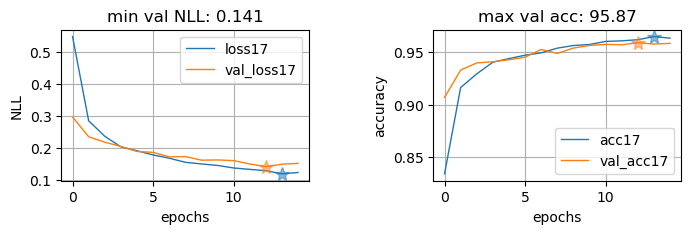

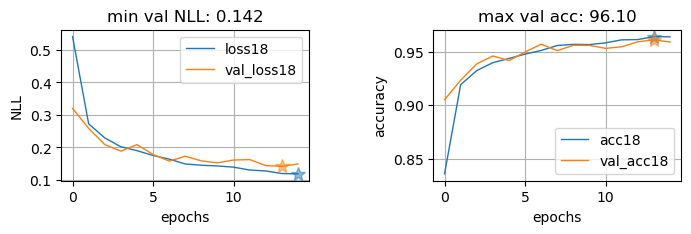

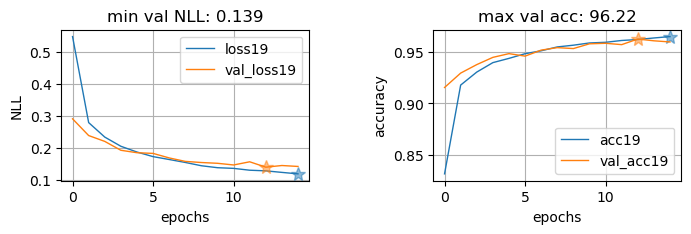

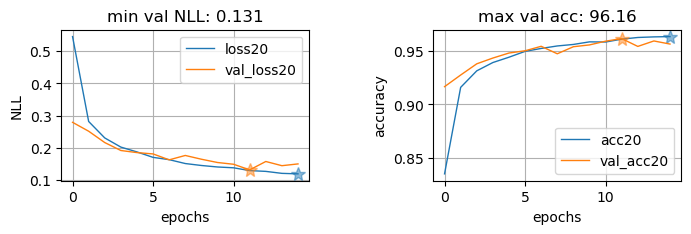

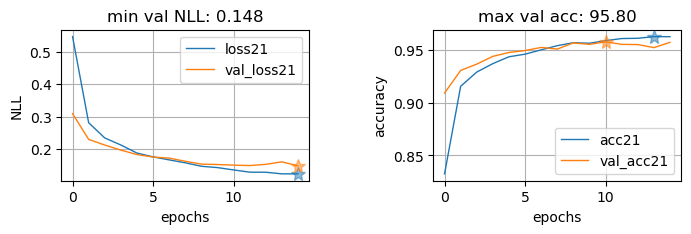

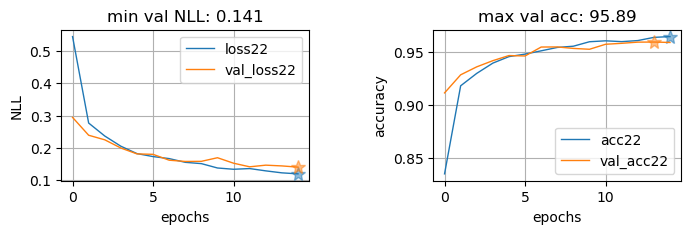

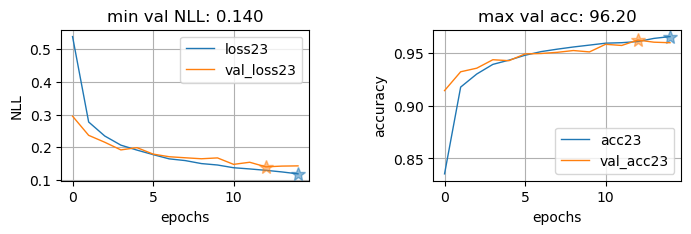

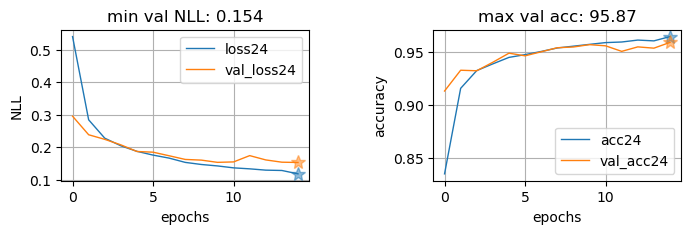

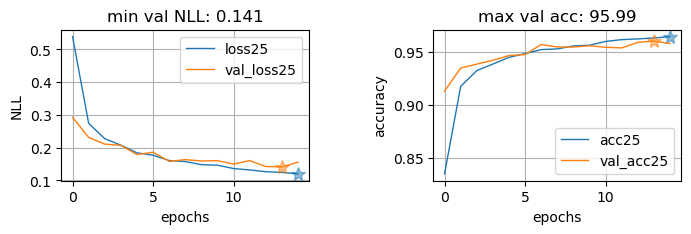

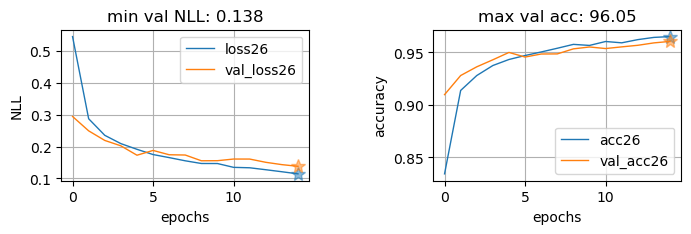

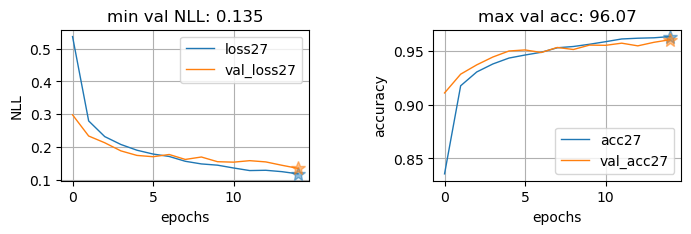

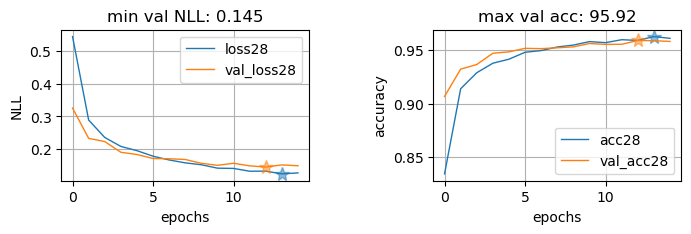

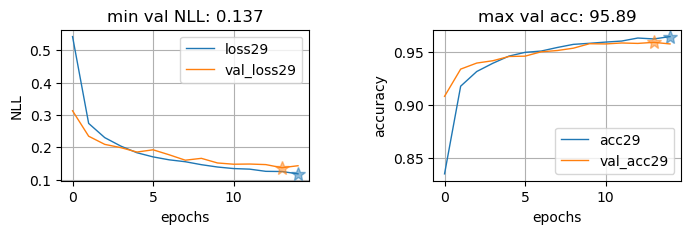

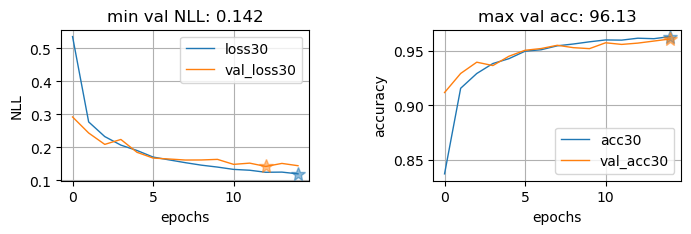

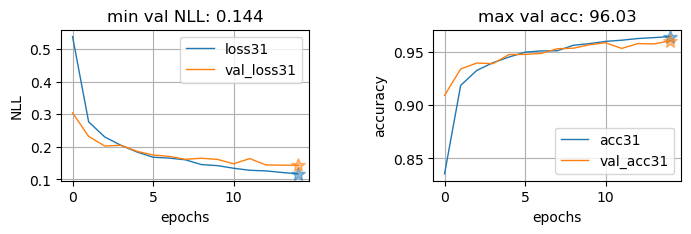

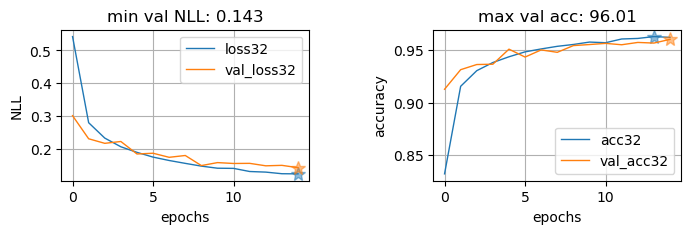

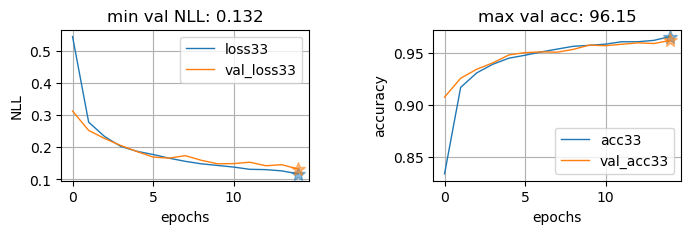

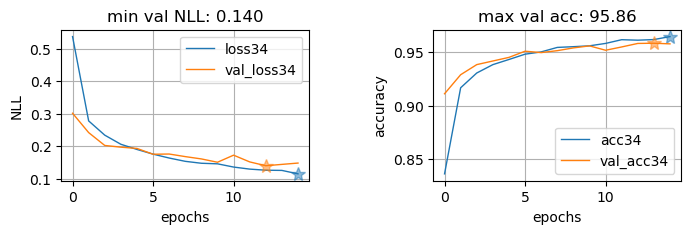

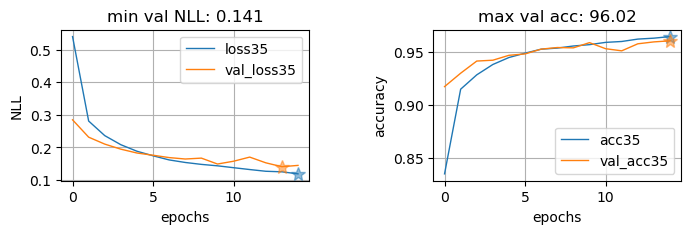

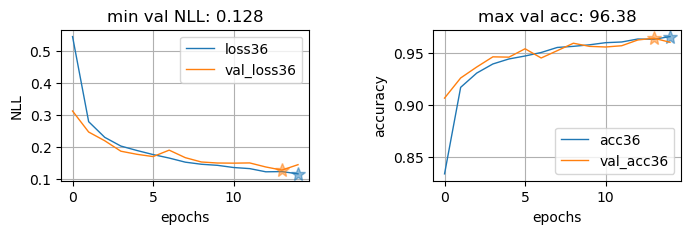

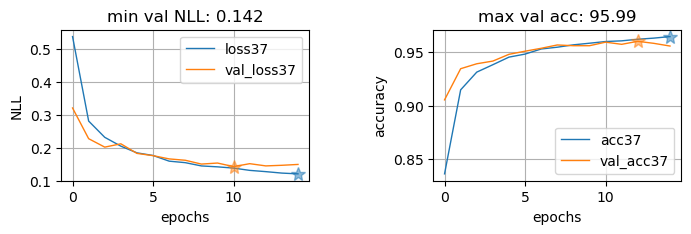

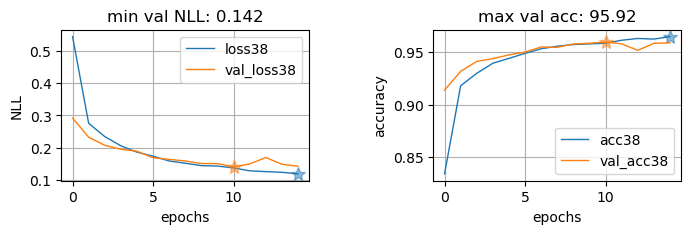

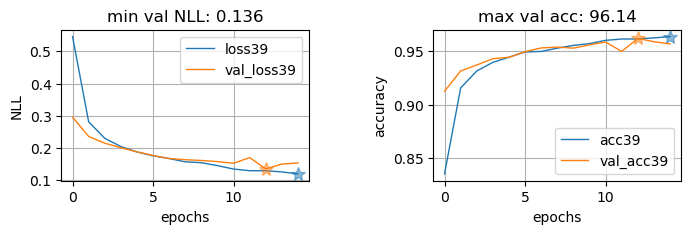

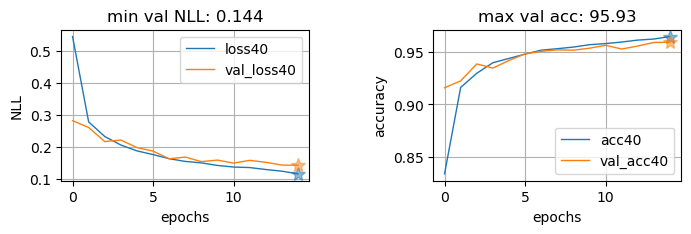

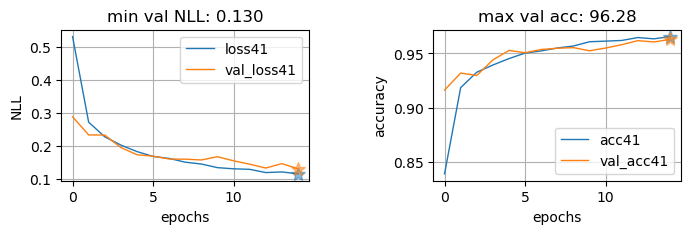

In [39]:
for i in range(17, 17+n_models):
    log = pd.read_csv(os.path.join(output_baseline_dropout_folder, str(i), 'log.csv'))
    plt.figure(figsize=(8,2),dpi=100)
    plt.subplots_adjust(wspace=0.5)
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    for metric_type in ['', 'val_']:
        for key in log.keys():
            if 'loss' in key and 'val' not in key:
                p = ax1.plot(log[metric_type+ key], label=metric_type + key+str(i), linewidth=1)
                c = p[-1].get_color()
                ax1.plot(np.argmin(log[metric_type+key]), np.amin(log[metric_type+key]), 
                         '*', markersize=10, alpha=0.5, color = c)
                ax1.set_title('min val NLL: {0:.3f}'.format(np.amin(log['val_' + key])))
                ax1.set_ylabel('NLL')
                ax1.set_xlabel('epochs')
            if 'acc' in key and 'val' not in key:
                p = ax2.plot(log[metric_type + key], label=metric_type + key+str(i), linewidth=1)
                c = p[-1].get_color()
                ax2.plot(np.argmax(log[metric_type + key]), np.amax(log[metric_type + key]), 
                         '*', markersize=10, alpha=0.5, color=c)
                ax2.set_title('max val acc: {0:.2f}'.format(np.amax(log['val_' + key]*100)))
                ax2.set_ylabel('accuracy')
                ax2.set_xlabel('epochs')
    ax1.grid()
    ax2.grid()
    ax1.legend()
    ax2.legend()

In [40]:
for index, model_id in enumerate(range(17, 17+n_models)):
    test_pred_path = os.path.join(model_folder, 'test_pred.npy')
    if not os.path.isfile(test_pred_path):
    # if True:
        model_folder = os.path.join(output_baseline_dropout_folder, str(model_id))
        checkpoint_path = glob.glob(model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp_mcdo(dropout=False)
        print('loading weights for model {}...'.format(model_id))
        model.load_weights(checkpoint_path)
        print('run inference...')
        test_pred = model.predict(x_test)
        np.save(test_pred_path, test_pred)

In [41]:
sample_model_id = 17
y_pred_sample = np.load(os.path.join(output_baseline_folder, str(sample_model_id), 'test_pred.npy'))
shape = np.shape(y_pred_sample)
all_test_preds = np.zeros((n_models, *shape))

In [42]:
d = []
for index, model_id in enumerate(range(17, 17 + n_models)):
    y_pred = np.load(os.path.join(output_baseline_dropout_folder, str(model_id), 'test_pred.npy'))
    all_test_preds[index] = y_pred
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_baselines_do = pd.DataFrame(d)

In [43]:
print('Baseline Dropout Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.2f}'.format(np.mean(df_baselines_do[metric]), np.std(df_baselines_do[metric])))
    print('-'*20)

BASELINE DROPOUT RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.079 ± 0.00
--------------------
BRIER
0.036 ± 0.00
--------------------
ECE
0.902 ± 0.11
--------------------
MCE
39.309 ± 17.86
--------------------
CLASSIFICATION ERROR
2.320 ± 0.14
--------------------


In [44]:
n_mcdo_ensemble = 25
for index, model_id in enumerate(range(17, 17+n_models)):
    model_folder = os.path.join(output_baseline_dropout_folder, str(model_id))
    output_mcdo_folder = os.path.join(model_folder, 'mcdo')
    if not os.path.isdir(output_mcdo_folder):
        os.mkdir(output_mcdo_folder)
    test_pred_path = os.path.join(output_mcdo_folder, 'test_pred_mcdo.npy')
    if not os.path.isfile(test_pred_path):
    #if True:
        checkpoint_path = glob.glob(model_folder + '/weights.' + str(epochs).zfill(2) + '*.hdf5')[0]
        model = mlp_mcdo()
        print('loading weights for model {}...'.format(model_id))
        model.load_weights(checkpoint_path)
        y_test_pred_ensemble = np.zeros((n_mcdo_ensemble, *y_test.shape))
        for index2, seed in enumerate(range(17, 17 + n_mcdo_ensemble)):
            np.random.seed(seed)
            y_test_pred_dropout = model.predict(x_test, verbose=1)
            y_test_pred_ensemble[index2] = y_test_pred_dropout
        y_pred = np.mean(y_test_pred_ensemble, axis=0)
        np.save(test_pred_path, y_pred)

In [45]:
d = list()
for index, model_id in enumerate(range(17, 17 + n_models)):
    model_mcdo_folder= os.path.join(output_baseline_dropout_folder, str(model_id),  'mcdo')
    y_pred = np.load(os.path.join(model_mcdo_folder, 'test_pred_mcdo.npy'))
    nll = log_loss(y_test, y_pred)
    error = classification_error(y_test, y_pred)
    br = brier_multi(y_test, y_pred)
    calib_erros = CalibrationErrors(y_test, y_pred, bin_size=1 / 20., min_samples=0)
    _, _, ece, mce, _ = calib_erros.calculate_calibration_errors()
    d.append(OrderedDict({"model":model_id, "nll": nll, "brier": br, "ece": ece, "mce":mce, "classification error": error}))
df_mcdo= pd.DataFrame(d)

In [46]:
df_mcdo

,model,nll,brier,ece,mce,classification error
0,17,0.095401,0.040128,2.802617,15.995721,2.45
1,18,0.096048,0.040929,2.691462,75.973520,2.42
2,19,0.096948,0.042116,2.527672,13.857075,2.60
3,20,0.100229,0.043558,2.595171,29.907060,2.61
4,21,0.091891,0.039613,2.581485,21.818130,2.37
5,22,0.095033,0.040920,2.577780,24.434110,2.40
6,23,0.092827,0.041046,2.294056,76.340237,2.69
7,24,0.094471,0.041704,2.420385,22.781254,2.59
8,25,0.095666,0.040994,2.864490,43.019410,2.52
9,26,0.085858,0.037246,2.669731,76.141602,2.22


In [47]:
print('MCDO Results (test set)'.upper())
print('-'*100)
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('{0}'.format(metric.upper()))
    print('{0:.3f} \u00B1 {1:.2f}'.format(np.mean(df_mcdo[metric]), np.std(df_mcdo[metric])))
    print('-'*20)

MCDO RESULTS (TEST SET)
----------------------------------------------------------------------------------------------------
NLL
0.094 ± 0.00
--------------------
BRIER
0.040 ± 0.00
--------------------
ECE
2.569 ± 0.17
--------------------
MCE
37.396 ± 22.22
--------------------
CLASSIFICATION ERROR
2.452 ± 0.14
--------------------


In [48]:
dfs = [df_baselines,
df_ppe,
df_ts,
df_mcdo,
df_deep_ensembles,
      ]

In [49]:
metrics = ['nll', 'brier', 'ece', 'mce', 'classification error']
for metric in metrics:
    print('% {}'.format(metric))
    for index, df in enumerate(dfs):
        if index != len(dfs)-1:
            print('{0:.3f} $\pm$ {1:.2f} &'.format(np.mean(df[metric]), np.std(df[metric])))
        else:
            print('{0:.3f} $\pm$ {1:.2f} \\\\'.format(np.mean(df[metric]), np.std(df[metric])))
    print('-'*100)

% nll
0.095 $\pm$ 0.01 &
0.079 $\pm$ 0.01 &
0.075 $\pm$ 0.01 &
0.094 $\pm$ 0.00 &
0.044 $\pm$ 0.00 \\
----------------------------------------------------------------------------------------------------
% brier
0.037 $\pm$ 0.00 &
0.035 $\pm$ 0.00 &
0.035 $\pm$ 0.00 &
0.040 $\pm$ 0.00 &
0.020 $\pm$ 0.00 \\
----------------------------------------------------------------------------------------------------
% ece
1.302 $\pm$ 0.19 &
0.528 $\pm$ 0.12 &
0.560 $\pm$ 0.70 &
2.569 $\pm$ 0.17 &
0.848 $\pm$ 0.08 \\
----------------------------------------------------------------------------------------------------
% mce
40.379 $\pm$ 14.80 &
37.673 $\pm$ 16.69 &
36.496 $\pm$ 20.17 &
37.396 $\pm$ 22.22 &
35.646 $\pm$ 17.16 \\
----------------------------------------------------------------------------------------------------
% classification error
2.255 $\pm$ 0.22 &
2.286 $\pm$ 0.24 &
2.255 $\pm$ 0.22 &
2.452 $\pm$ 0.14 &
1.294 $\pm$ 0.05 \\
---------------------------------------------------------